# 5.0 Modelling

---

# Contents
    
- [1.0 About ARIMAX Model](#1.0-About-ARIMAX-Model)
- [2.0 Load Data](#2.0-Load-Data)
    - [2.1 EUR/USD Data](#2.1-EUR/USD-Data)
    - [2.2 Pattern Data](#2.2-Pattern-Data)
- [3.0 Model](#3.0-Model)
    - [3.1 Train/Test Split](#3.1-Train/Test-Split)
    - [3.2 Fit Model](#3.2-Fit-Model)
    - [3.3 Calculate Results](#3.3-Calculate-Results)
    - [3.4 Run Model](#3.4-Run-Model)
- [4.0 Results](#4.0-Results)
- [5.0 Observations](#5.0-Observations)



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_squared_error
from pmdarima import auto_arima
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


In [2]:
pd.set_option('display.max_columns', None)

---

# 1.0 About ARIMAX Model

The Arima model has 3 components:

+ Differencing Step - I - Integrated - Check for stationarity
+ Autoregressive Piece - AR - long term trends
+ Moving Average Piece - MA - Modelling sudden fluctuations

Each part has input into the model P, D, Q.

+ D is the order of differencing we found using the Augmented Dickey-Fuller test.
+ P is the number of autoregressive terms in our model. PACF is used to estimate this.
+ Q is to do with looking at the moving average.
    + If PACF has a sharp cut off and lag-1 for the ACF is negative choose q to be the lag in the ACF before cut off.
    + If PACF does not have a sharp cut off or lag -1 ACF is not negative choose q = 0

Therefore based on the charts before I will use:
    
    + p = 1
    + d = 1
    + q = 0
    
However I will use auto_arima to help decide.

The X in the model stands for Exogenous features which are external features away from the time frame. The time series models look at time as a key factor. This is accurate when time is a key feature in determining price. For example stock control will be lnked to time as the more time the less stock is liekly.

The FOREX market has a lot of external features which are important to drive the prices. Therefore I added gold price, volatility and 2 Moving Averages. The idea is the model can use the extra information to help predict the price.

---

In [3]:
# results = {'algo':'','name':'','date':'', 'time_frame':'','success':0,'RMSE':0, 'MSE':0, 'classification':'' }

# 2.0 Load Data

## 2.1 EUR/USD Data

In [4]:
daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usddailyMarubozu.csv', index_col='date', parse_dates=True)
# daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usd2daily.csv', 
#                     index_col='date', parse_dates=True)

In [5]:
# daily.loc[(daily.index >= '2000-10-6') & (daily.index <= '2000-10-18')]

In [6]:
daily.columns

Index(['open', 'high', 'low', 'close', 'mid', 'wk_mv_avg', 'mnth_mv_avg',
       'volatility_3_day', 'volatility_10_day', 'pct_chge_3_prds',
       'pct_chge_5_prds', 'pct_chge_10_prds', 'height', 'height-1', 'height-2',
       'height-3', 'direction', 'gold_usd', 'gold_euro', 'marubozu',
       'marubozu+1', 'marubozu-1', 'marubozu-2', 'day-1_open', 'day-2_open',
       'day-3_open', 'day-1_high', 'day-2_high', 'day-3_high', 'day-1_low',
       'day-2_low', 'day-3_low', 'day-1_close', 'day-2_close', 'day-3_close',
       'day+1_open', 'day+1_high', 'day+1_low', 'day+1_close', 'day+2_high',
       'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high', 'day+4_low',
       'day+5_high', 'day+5_low', 'exit_price', 'select', 'target', 'date+5'],
      dtype='object')

In [7]:
daily.head(20)

,open,high,low,close,mid,wk_mv_avg,mnth_mv_avg,volatility_3_day,volatility_10_day,pct_chge_3_prds,pct_chge_5_prds,pct_chge_10_prds,height,height-1,height-2,height-3,direction,gold_usd,gold_euro,marubozu,marubozu+1,marubozu-1,marubozu-2,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+2_low,day+3_high,day+3_low,day+4_high,day+4_low,day+5_high,day+5_low,exit_price,select,target,date+5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-07-14,0.9353,0.9389,0.9318,0.9383,0.93680,0.94522,0.948145,0.003250,0.003387,-0.016431,-0.014102,-0.017514,0.0030,0.0062,0.0086,0.0041,1.0,97.4,122.0,0,0.0,-1.0,-1.0,0.9416,0.9503,0.9545,0.9425,0.9517,0.9569,0.9330,0.9396,0.9496,0.9354,0.9417,0.9504,0.9382,0.9402,0.9342,0.9360,0.9368,0.9227,0.9270,0.9193,0.9342,0.9204,0.9384,0.9319,0.9413,0,0.9402,2000-07-21
2000-07-17,0.9382,0.9402,0.9342,0.9360,0.93710,0.94217,0.947100,0.004282,0.003440,-0.009408,-0.016013,-0.014875,0.0022,0.0030,0.0062,0.0086,-1.0,98.1,123.3,0,-1.0,0.0,-1.0,0.9353,0.9416,0.9503,0.9389,0.9425,0.9517,0.9318,0.9330,0.9396,0.9383,0.9354,0.9417,0.9361,0.9368,0.9227,0.9256,0.9270,0.9193,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.9338,0,0.9193,2000-07-24
2000-07-18,0.9361,0.9368,0.9227,0.9256,0.93085,0.93785,0.945633,0.003582,0.003797,-0.008151,-0.022678,-0.020519,0.0105,0.0022,0.0030,0.0062,-1.0,98.3,123.8,-1,0.0,0.0,0.0,0.9382,0.9353,0.9416,0.9402,0.9389,0.9425,0.9342,0.9318,0.9330,0.9360,0.9383,0.9354,0.9255,0.9270,0.9193,0.9246,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.9151,0,0.9193,2000-07-25
2000-07-19,0.9255,0.9270,0.9193,0.9246,0.92505,0.93366,0.944207,0.003915,0.003618,-0.012543,-0.022146,-0.029125,0.0009,0.0105,0.0022,0.0030,-1.0,97.0,123.3,0,1.0,-1.0,0.0,0.9361,0.9382,0.9353,0.9368,0.9402,0.9389,0.9227,0.9342,0.9318,0.9256,0.9360,0.9383,0.9245,0.9342,0.9204,0.9325,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.9237,0,0.9204,2000-07-26
2000-07-20,0.9245,0.9342,0.9204,0.9325,0.92850,0.93166,0.943221,0.005881,0.004167,-0.009177,-0.010655,-0.024531,0.0080,0.0009,0.0105,0.0022,1.0,97.1,123.3,1,0.0,0.0,-1.0,0.9255,0.9361,0.9382,0.9270,0.9368,0.9402,0.9193,0.9227,0.9342,0.9246,0.9256,0.9360,0.9324,0.9384,0.9319,0.9365,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.9444,0.9314,0.9405,0,0.9450,2000-07-27
2000-07-21,0.9324,0.9384,0.9319,0.9365,0.93445,0.93119,0.942879,0.006660,0.005033,0.003867,-0.002509,-0.016575,0.0041,0.0080,0.0009,0.0105,1.0,97.1,122.2,0,0.0,1.0,0.0,0.9245,0.9255,0.9361,0.9342,0.9270,0.9368,0.9204,0.9193,0.9227,0.9325,0.9246,0.9256,0.9366,0.9367,0.9313,0.9330,0.9433,0.9329,0.9450,0.9391,0.9444,0.9314,0.9338,0.9229,0.9406,0,0.9450,2000-07-28
2000-07-24,0.9366,0.9367,0.9313,0.9330,0.93480,0.93073,0.942807,0.003023,0.004904,0.010540,-0.002454,-0.018428,0.0036,0.0041,0.0080,0.0009,-1.0,97.2,122.3,0,1.0,0.0,1.0,0.9324,0.9245,0.9255,0.9384,0.9342,0.9270,0.9319,0.9204,0.9193,0.9365,0.9325,0.9246,0.9329,0.9433,0.9329,0.9412,0.9450,0.9391,0.9444,0.9314,0.9338,0.9229,0.9295,0.9224,0.9294,0,0.9224,2000-07-31
2000-07-25,0.9329,0.9433,0.9329,0.9412,0.93705,0.93197,0.942790,0.003070,0.005057,0.009208,0.006661,-0.016169,0.0083,0.0036,0.0041,0.0080,1.0,97.2,121.2,1,0.0,0.0,0.0,0.9366,0.9324,0.9245,0.9367,0.9384,0.9342,0.9313,0.9319,0.9204,0.9330,0.9365,0.9325,0.9411,0.9450,0.9391,0.9435,0.9444,0.9314,0.9338,0.9229,0.9295,0.9224,0.9293,0.9135,0.9495,0,0.9450,2000-08-01
2000-07-26,0.9411,0.9450,0.9391,0.9435,0.94230,0.93542,0.942795,0.002636,0.005168,0.008401,0.018648,-0.003911,0.0024,0.0083,0.0036,0.0041,1.0,97.1,121.0,0,-1.0,1.0,0.0,0.9329,0.9366,0.9324,0.9433,0.9367,0.9384,0.9329,0.9313,0.9319,0.9412,0.9330,0.9365,0.9434,0.9444,0.9314,0.9319,0.9338,0.9229,0.9295,0.9224,0.9293,0.9135,0.9192,0.9117,0.9459,0,0.9444,2000-08-02


In [8]:
### Get correct hyper parameters

In [9]:
## Arima
auto_arima(daily['close'].dropna(), seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4612
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15826.945
Date:                Thu, 06 Aug 2020   AIC                         -31651.890
Time:                        00:50:41   BIC                         -31645.453
Sample:                             0   HQIC                        -31649.624
                               - 4612                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       6.11e-05   5.15e-07    118.588      0.000    6.01e-05    6.21e-05
===================================================================================
Ljung-Box (Q):                       61.33   Jarque-Bera (JB):             20105.01
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---

## 2.2 Pattern Data

In [10]:
daily_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/patterns/dailyMarubozu.csv', 
                           parse_dates=True)

In [11]:
daily_pattern.head()

,pattern_end
0,2000-10-11
1,2000-10-20
2,2001-04-05
3,2001-04-09
4,2001-08-20


In [12]:
daily_pattern['pattern_end'] = pd.to_datetime(daily_pattern['pattern_end'])

In [13]:
daily_pattern.loc[0]

pattern_end   2000-10-11
Name: 0, dtype: datetime64[ns]

In [14]:
len(daily_pattern)

64

---

# 3.0 Model

## 3.1 Train/Test Split

In [15]:
def create_train_test_split(date, time_series, model_info):

    # Get index of pattern and add 6 (so 5) extra rows for Test/train set
    test_end_loc = time_series.index.get_loc(date) + 6
    
    # Create train/test set using index loc of pattern 
    train_test = time_series.iloc[:test_end_loc]
    
    # Set target values
    target_value = time_series.loc[time_series.index == date,'exit_price'].item()
    
    # add target price to dataset
    train_test.insert(0, 'target_price', target_value)
    
    # Add Signal so it can be determined whether we expect the price to go up or down.
    model_info['signal'] = time_series.loc[date,'marubozu']
    
    # insert the signal to dataset
    train_test.insert(0, 'signal', model_info['signal'])
    
    # create start and end points for the test/train splits
    model_info['start'] = len(train_test)-5
    model_info['end'] = len(train_test)-1
    
    # create the train and data sets
    model_info['train'] = train_test.iloc[:model_info['start']]
    model_info['test'] = train_test.iloc[model_info['start']:]

    return model_info

## 3.2 Fit Model

In [16]:
def train_arima(model_info, p=0, d=1, q=0):
    
    exog = np.column_stack([model_info['train']['mnth_mv_avg'], 
                            model_info['train']['wk_mv_avg'],
                            model_info['train']['volatility_3_day'],
                            model_info['train']['gold_euro'],
                            model_info['train']['gold_usd']])
    
    if model_info['signal'] == -1:
        model = ARIMA(model_info['train']['low'], exog=exog, order=(p,d,q))
    else:
        model = ARIMA(model_info['train']['high'], exog=exog, order=(p,d,q))

    results = model.fit()
    predictions = results.predict(start=model_info['start'], 
                                  end=model_info['end'], exog=exog,
                                  dynamic=True, 
                                  typ='levels').rename('ARIMA-0-1-0 Predictions')
    
    return results, predictions

## 3.3 Calculate Results

In [17]:
def meet_threshold(row):
    if row['signal'] == -1 and row['low'] <= row['target_price']:
        return -1
    elif row['signal'] == 1 and row['high'] >= row['target_price']:
        return 1    
    else:
        return 0

In [18]:
def ml_decision(row):
    if row['direction'] == -1 and row['preds'] <= row['target_price']:
        return -1
    elif row['direction'] == 1 and row['preds'] >= row['target_price']:
        return 1    
    else:
        return 0

In [19]:
def create_results_outcomes_dataframe(test, predictions):    
    outcomes = pd.DataFrame()
    outcomes['low'] = test['low']
    outcomes['high'] = test['high']
    outcomes['preds'] = predictions.values
    outcomes['target_price'] = test['target_price']
    outcomes['direction'] = test['signal']
    outcomes['correct_call'] = test.apply(meet_threshold, axis=1)
    return outcomes

In [20]:
def print_chart(outcomes):
    if model_info['signal'] == -1:
        outcomes['low'].plot(legend=False, figsize=(12,8))
    else:
        outcomes['high'].plot(legend=False, figsize=(12,8))

    outcomes['preds'].plot(legend=False);
    outcomes['target_price'].plot(legend=False);

In [21]:
def get_results(model_info):
        
    if model_info['signal'] == -1:
        mse = mean_squared_error(model_info['test']['low'], predictions)
        rmse_res = rmse(model_info['test']['low'], predictions)
    else:
        mse = mean_squared_error(model_info['test']['high'], predictions)
        rmse_res = rmse(model_info['test']['high'], predictions)       
    
    return rmse_res, mse

In [22]:
def classify(outcomes):
    
    if max(outcomes['direction']) == 1:
        
        if max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 1:
            return 'tp'
        elif max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 1:
            return 'fp'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    elif max(outcomes['direction']) == -1:
        
        if min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == -1:
            return 'tp'
        elif min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == -1:
            return 'fp'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    else:
        return 'ERROR'
    

## 3.4 Run Model

In [23]:
arima_results = []

for match in daily_pattern['pattern_end']:
    
    model_info = {"train":None,"test":None,"start":None,"end":None,"signal":None}

    
    results_dict = {'name':'arima-0-1-0','strategy':'marubozu','date':match,
                   'time_frame':'daily','RMSE':None,
                   'MSE':None, 'classification':None}
    

    model_info = create_train_test_split(match, daily, model_info)

    if len(model_info['train']) < 10:
        continue

    results, predictions = train_arima(model_info)
    

    outcomes = create_results_outcomes_dataframe(model_info['test'], predictions)
    outcomes['ml_correct_call'] = outcomes.apply(ml_decision, axis=1)

    results_dict['RMSE'], results_dict['MSE'] = get_results(model_info)
    results_dict['classification'] = classify(outcomes)

    arima_results.append(results_dict)
    

In [24]:
# Check no errors
def check_no_errors(results_list):
    errors = 0
    for result in arima_results:
        res = result['classification']
        if res == 'ERROR':
            errors+=1
    
    if errors == 0:
        print("All patterns recorded correctly")
    elif errors > 0:
        print(f"Warning: there were {errors} errors recorded")

In [25]:
check_no_errors(arima_results)

All patterns recorded correctly


---

# 4.0 Results

In [26]:
def create_cm(arima_results):
    
    res_cm = [[0,0],
              [0,0]]
    
    for result in arima_results:
        res = result['classification']
        
        if res == 'tp':
            res_cm[0][0] += 1
        elif res == 'fp':
            res_cm[0][1] += 1
        elif res == 'fn':
            res_cm[1][0] += 1
        elif res == 'tn':
            res_cm[1][1] += 1
    
    return res_cm

In [27]:
cm = create_cm(arima_results)

In [28]:
cm_df = pd.DataFrame(cm, index=['pred_success', 'pred_non_success'], columns=['actual success', 'actual non_success'])
cm_df

,actual success,actual non_success
pred_success,14,5
pred_non_success,27,18


In [29]:
def print_metrics(cm):
    # Accuracy - how many did the model get right
    # Total number of correct predictions / total number of predictions
    acc= (cm[0][0]+cm[1][1])/(np.sum(cm))
    
    # Precision proportion of positive identifications that were actually correct
    # True positives/ true positives + false positives)
    prec = cm[0][0]/(cm[0][0]+cm[0][1])
    
    # Recall - proportion of actual positives that were correctly defined
    # True positives/ true positives + false negatives
    rec = cm[0][0]/(cm[0][0]+cm[1][0])

    print(f"Accuracy:\t{round(acc,2)}\nPrecision:\t{round(prec,2)}\nRecall:\t\t{round(rec,2)}")


In [30]:
# Display the results
print_metrics(cm)

Accuracy:	0.5
Precision:	0.74
Recall:		0.34


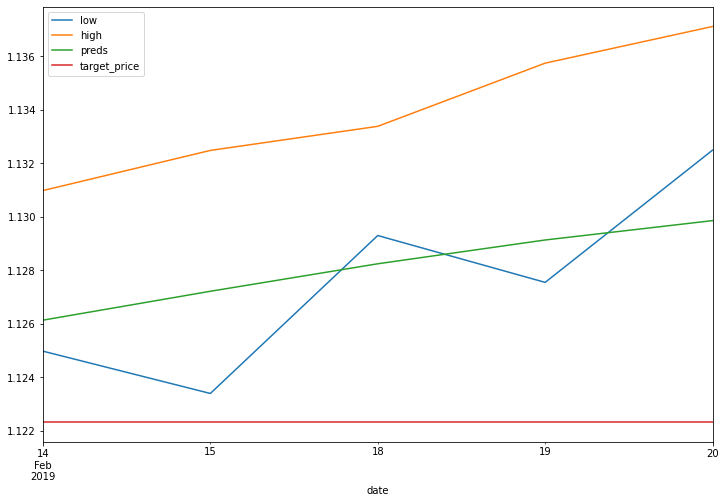

In [31]:
outcomes['low'].plot(legend=True, figsize=(12,8))
outcomes['high'].plot(legend=True)
outcomes['preds'].plot(legend=True);
outcomes['target_price'].plot(legend=True);


In [32]:
arima_results_df = pd.DataFrame(arima_results)
arima_results_df

,name,strategy,date,time_frame,RMSE,MSE,classification
0,arima-0-1-0,marubozu,2000-10-11,daily,0.004065,0.000017,tp
1,arima-0-1-0,marubozu,2000-10-20,daily,0.011222,0.000126,tp
2,arima-0-1-0,marubozu,2001-04-05,daily,0.006349,0.000040,tp
3,arima-0-1-0,marubozu,2001-04-09,daily,0.006417,0.000041,tp
4,arima-0-1-0,marubozu,2001-08-20,daily,0.009487,0.000090,tp
...,...,...,...,...,...,...,...
59,arima-0-1-0,marubozu,2018-09-17,daily,0.004317,0.000019,tp
60,arima-0-1-0,marubozu,2018-10-22,daily,0.012050,0.000145,fn
61,arima-0-1-0,marubozu,2018-12-10,daily,0.008124,0.000066,fn
62,arima-0-1-0,marubozu,2019-01-31,daily,0.009717,0.000094,fn


In [33]:
# Save resutls
arima_results_df.to_csv('/Users/stuartdaw/Documents/Capstone_data/model_results/arima_results_mb.csv', index=False)

---

# 2.0 Load Data

## 2.1 EUR/USD Data

In [34]:
daily_fractals = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usddailyfractals.csv', index_col='date', parse_dates=True)
# daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usd2daily.csv', 
#                     index_col='date', parse_dates=True)

In [35]:
# daily.loc[(daily.index >= '2000-10-6') & (daily.index <= '2000-10-18')]

In [36]:
daily_fractals.columns

Index(['open', 'high', 'low', 'close', 'mid', 'wk_mv_avg', 'mnth_mv_avg',
       'volatility_3_day', 'volatility_10_day', 'pct_chge_3_prds',
       'pct_chge_5_prds', 'pct_chge_10_prds', 'height', 'height-1', 'height-2',
       'height-3', 'direction', 'gold_usd', 'gold_euro', 'day-1_high',
       'day-2_high', 'day-3_high', 'day-4_high', 'day-1_low', 'day-2_low',
       'day-3_low', 'day-4_low', 'day-1_open', 'day-2_open', 'day-3_open',
       'day-4_open', 'day-1_close', 'day-2_close', 'day-3_close',
       'day-4_close', 'day+1_open', 'day+1_high', 'day+1_low', 'day+1_close',
       'day+2_high', 'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high',
       'day+4_low', 'day+5_high', 'day+5_low', '5_day_avg', 'fractal_end',
       'day+1_frac', 'day+2_frac', 'day+3_frac', 'day+4_frac', 'select',
       'exit_price', 'target', 'date+5', 'fractal'],
      dtype='object')

In [37]:
daily_fractals.head(20)

,open,high,low,close,mid,wk_mv_avg,mnth_mv_avg,volatility_3_day,volatility_10_day,pct_chge_3_prds,pct_chge_5_prds,pct_chge_10_prds,height,height-1,height-2,height-3,direction,gold_usd,gold_euro,day-1_high,day-2_high,day-3_high,day-4_high,day-1_low,day-2_low,day-3_low,day-4_low,day-1_open,day-2_open,day-3_open,day-4_open,day-1_close,day-2_close,day-3_close,day-4_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+2_low,day+3_high,day+3_low,day+4_high,day+4_low,day+5_high,day+5_low,5_day_avg,fractal_end,day+1_frac,day+2_frac,day+3_frac,day+4_frac,select,exit_price,target,date+5,fractal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-07-17,0.9382,0.9402,0.9342,0.9360,0.93710,0.94217,0.947100,0.004282,0.003440,-0.009408,-0.016013,-0.014875,0.0022,0.0030,0.0062,0.0086,0,98.1,123.3,0.9389,0.9425,0.9517,0.9569,0.9318,0.9330,0.9396,0.9496,0.9353,0.9416,0.9503,0.9545,0.9383,0.9354,0.9417,0.9504,0.9361,0.9368,0.9227,0.9256,0.9270,0.9193,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.00500,0,0.0,0.0,0.0,-1.0,0,0.93600,0.0000,2000-07-24,0
2000-07-18,0.9361,0.9368,0.9227,0.9256,0.93085,0.93785,0.945633,0.003582,0.003797,-0.008151,-0.022678,-0.020519,0.0105,0.0022,0.0030,0.0062,0,98.3,123.8,0.9402,0.9389,0.9425,0.9517,0.9342,0.9318,0.9330,0.9396,0.9382,0.9353,0.9416,0.9503,0.9360,0.9383,0.9354,0.9417,0.9255,0.9270,0.9193,0.9246,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.00610,0,0.0,0.0,-1.0,0.0,0,0.92560,0.0000,2000-07-25,0
2000-07-19,0.9255,0.9270,0.9193,0.9246,0.92505,0.93366,0.944207,0.003915,0.003618,-0.012543,-0.022146,-0.029125,0.0009,0.0105,0.0022,0.0030,0,97.0,123.3,0.9368,0.9402,0.9389,0.9425,0.9227,0.9342,0.9318,0.9330,0.9361,0.9382,0.9353,0.9416,0.9256,0.9360,0.9383,0.9354,0.9245,0.9342,0.9204,0.9325,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.00500,0,0.0,-1.0,0.0,0.0,0,0.92460,0.0000,2000-07-26,0
2000-07-20,0.9245,0.9342,0.9204,0.9325,0.92850,0.93166,0.943221,0.005881,0.004167,-0.009177,-0.010655,-0.024531,0.0080,0.0009,0.0105,0.0022,0,97.1,123.3,0.9270,0.9368,0.9402,0.9389,0.9193,0.9227,0.9342,0.9318,0.9255,0.9361,0.9382,0.9353,0.9246,0.9256,0.9360,0.9383,0.9324,0.9384,0.9319,0.9365,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.9444,0.9314,0.00500,0,-1.0,0.0,0.0,0.0,0,0.93250,0.0000,2000-07-27,0
2000-07-21,0.9324,0.9384,0.9319,0.9365,0.93445,0.93119,0.942879,0.006660,0.005033,0.003867,-0.002509,-0.016575,0.0041,0.0080,0.0009,0.0105,-1,97.1,122.2,0.9342,0.9270,0.9368,0.9402,0.9204,0.9193,0.9227,0.9342,0.9245,0.9255,0.9361,0.9382,0.9325,0.9246,0.9256,0.9360,0.9366,0.9367,0.9313,0.9330,0.9433,0.9329,0.9450,0.9391,0.9444,0.9314,0.9338,0.9229,0.00514,-1,0.0,0.0,0.0,0.0,1,0.93136,0.9229,2000-07-28,0
2000-07-24,0.9366,0.9367,0.9313,0.9330,0.93480,0.93073,0.942807,0.003023,0.004904,0.010540,-0.002454,-0.018428,0.0036,0.0041,0.0080,0.0009,0,97.2,122.3,0.9384,0.9342,0.9270,0.9368,0.9319,0.9204,0.9193,0.9227,0.9324,0.9245,0.9255,0.9361,0.9365,0.9325,0.9246,0.9256,0.9329,0.9433,0.9329,0.9412,0.9450,0.9391,0.9444,0.9314,0.9338,0.9229,0.9295,0.9224,0.00542,0,0.0,0.0,0.0,1.0,0,0.93300,0.0000,2000-07-31,2
2000-07-25,0.9329,0.9433,0.9329,0.9412,0.93705,0.93197,0.942790,0.003070,0.005057,0.009208,0.006661,-0.016169,0.0083,0.0036,0.0041,0.0080,0,97.2,121.2,0.9367,0.9384,0.9342,0.9270,0.9313,0.9319,0.9204,0.9193,0.9366,0.9324,0.9245,0.9255,0.9330,0.9365,0.9325,0.9246,0.9411,0.9450,0.9391,0.9435,0.9444,0.9314,0.9338,0.9229,0.9295,0.9224,0.9293,0.9135,0.00500,0,0.0,0.0,1.0,0.0,0,0.94120,0.0000,2000-08-01,2
2000-07-26,0.9411,0.9450,0.9391,0.9435,0.94230,0.93542,0.942795,0.002636,0.005168,0.008401,0.018648,-0.003911,0.0024,0.0083,0.0036,0.0041,0,97.1,121.0,0.9433,0.9367,0.9384,0.9342,0.9329,0.9313,0.9319,0.9204,0.9329,0.9366,0.9324,0.9245,0.9412,0.9330,0.9365,0.9325,0.9434,0.9444,0.9314,0.9319,0.9338,0.9229,0.9295,0.9224,0.9293,0.9135,0.9192,0.9117,0.00528,0,0.0,1.0,0.0,0.0,0,0.94350,0.0000,2000-08-02,2
2000-07-27,0.9434,0.9444,0.9314,0.9319,0.93765,0.93725,0.942469,0.005403,0.004752,0.003049,0.

In [38]:
### Get correct hyper parameters

---

## 2.2 Pattern Data

In [39]:
fractal_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/patterns/dailyfractals.csv', 
                           parse_dates=True)

In [40]:
fractal_pattern.head()

,pattern_end
0,2000-07-21
1,2000-07-28
2,2000-08-07
3,2000-08-22
4,2000-08-29


In [41]:
fractal_pattern['pattern_end'] = pd.to_datetime(fractal_pattern['pattern_end'])

In [42]:
fractal_pattern.loc[0]

pattern_end   2000-07-21
Name: 0, dtype: datetime64[ns]

In [43]:
len(fractal_pattern)

613

---

# 3.0 Model

## 3.1 Train/Test Split

In [44]:
# def create_train_test_split(date, time_series, model_info):
# #     test_end_date = time_series.loc[date,'date+5']
#     test_end_loc = time_series.index.get_loc(date) + 6

# #     train_test = time_series.loc[time_series.index <= test_end_date]
#     train_test = time_series.iloc[:test_end_loc]

#     target_value = time_series.loc[time_series.index == date,'exit_price'].item()
    
#     train_test.insert(0, 'target_price', target_value)
    
#     model_info['signal'] = time_series.loc[date,'fractal_end']
    
#     train_test.insert(0, 'signal', model_info['signal'])
    
#     model_info['start'] = len(train_test)-5
#     model_info['end'] = len(train_test)-1
    
#     model_info['train'] = train_test.iloc[:model_info['start']]
#     model_info['test'] = train_test.iloc[model_info['start']:]

#     return model_info

In [45]:
def create_train_test_split(date, time_series, model_info):

    # Get index of pattern and add 6 (so 5) extra rows for Test/train set
    test_end_loc = time_series.index.get_loc(date) + 6
    
    # Create train/test set using index loc of pattern 
    train_test = time_series.iloc[:test_end_loc]
    
    # Set target values
    target_value = time_series.loc[time_series.index == date,'exit_price'].item()
    
    # add target price to dataset
    train_test.insert(0, 'target_price', target_value)
    
    # Add Signal so it can be determined whether we expect the price to go up or down.
    model_info['signal'] = time_series.loc[date,'fractal_end']
    
    # insert the signal to dataset
    train_test.insert(0, 'signal', model_info['signal'])
    
    # create start and end points for the test/train splits
    model_info['start'] = len(train_test)-5
    model_info['end'] = len(train_test)-1
    
    # create the train and data sets
    model_info['train'] = train_test.iloc[:model_info['start']]
    model_info['test'] = train_test.iloc[model_info['start']:]

    return model_info

## 3.2 Fit Model

In [46]:
def train_arima(model_info, p=0, d=1, q=0):
    
    exog = np.column_stack([model_info['train']['mnth_mv_avg'], 
                            model_info['train']['wk_mv_avg'],
                            model_info['train']['volatility_3_day'],
                            model_info['train']['gold_euro'],
                            model_info['train']['gold_usd']])
    
    if model_info['signal'] == -1:
        model = ARIMA(model_info['train']['low'], exog=exog, order=(p,d,q))
    else:
        model = ARIMA(model_info['train']['high'], exog=exog, order=(p,d,q))

    results = model.fit()
    predictions = results.predict(start=model_info['start'], 
                                  end=model_info['end'], exog=exog,
                                  dynamic=True, 
                                  typ='levels').rename('ARIMA-0-1-0 Predictions')
    
    return results, predictions

## 3.3 Calculate Results

In [47]:
def meet_threshold(row):
    if row['signal'] == -1 and row['low'] <= row['target_price']:
        return -1
    elif row['signal'] == 1 and row['high'] >= row['target_price']:
        return 1    
    else:
        return 0

In [48]:
def ml_decision(row):
    if row['direction'] == -1 and row['preds'] <= row['target_price']:
        return -1
    elif row['direction'] == 1 and row['preds'] >= row['target_price']:
        return 1    
    else:
        return 0

In [49]:
def create_results_outcomes_dataframe(test, predictions):    
    outcomes = pd.DataFrame()
    outcomes['low'] = test['low']
    outcomes['high'] = test['high']
    outcomes['preds'] = predictions.values
    outcomes['target_price'] = test['target_price']
    outcomes['direction'] = test['signal']
    outcomes['correct_call'] = test.apply(meet_threshold, axis=1)
    return outcomes

In [50]:
def print_chart(outcomes):
    if model_info['signal'] == -1:
        outcomes['low'].plot(legend=False, figsize=(12,8))
    else:
        outcomes['high'].plot(legend=False, figsize=(12,8))

    outcomes['preds'].plot(legend=False);
    outcomes['target_price'].plot(legend=False);

In [51]:
def get_results(model_info):
        
    if model_info['signal'] == -1:
        mse = mean_squared_error(model_info['test']['low'], predictions)
        rmse_res = rmse(model_info['test']['low'], predictions)
    else:
        mse = mean_squared_error(model_info['test']['high'], predictions)
        rmse_res = rmse(model_info['test']['high'], predictions)       
    
    return rmse_res, mse

In [52]:
def classify(outcomes):
    
    if max(outcomes['direction']) == 1:
        
        if max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 1:
            return 'tp'
        elif max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 1:
            return 'fp'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    elif max(outcomes['direction']) == -1:
        
        if min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == -1:
            return 'tp'
        elif min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == -1:
            return 'fp'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    else:
        return 'ERROR'
    

## 3.4 Run Model

In [64]:
arima_results = []

for match in fractal_pattern['pattern_end']:
    
    model_info = {"train":None,"test":None,"start":None,"end":None,"signal":None}

    
    results_dict = {'name':'arima-0-1-0','strategy':'fractals','date':match,
                   'time_frame':'daily','RMSE':None,
                   'MSE':None, 'classification':None}
    

    model_info = create_train_test_split(match, daily_fractals, model_info)

    if len(model_info['train']) < 10:
        continue

    results, predictions = train_arima(model_info)
    

    outcomes = create_results_outcomes_dataframe(model_info['test'], predictions)
    outcomes['ml_correct_call'] = outcomes.apply(ml_decision, axis=1)

    results_dict['RMSE'], results_dict['MSE'] = get_results(model_info)
    results_dict['classification'] = classify(outcomes)

    print(results_dict['classification'])
    print(outcomes)
    arima_results.append(results_dict)
    

tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2000-07-31  0.9224  0.9295  0.927770       0.93084          1             0   
2000-08-01  0.9135  0.9293  0.925484       0.93084          1             0   
2000-08-02  0.9117  0.9192  0.917767       0.93084          1             0   
2000-08-03  0.8997  0.9174  0.916724       0.93084          1             0   
2000-08-04  0.9015  0.9103  0.923812       0.93084          1             0   

            ml_correct_call  
date                         
2000-07-31                0  
2000-08-01                0  
2000-08-02                0  
2000-08-03                0  
2000-08-04                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2000-08-08  0.8982  0.9084  0.895406       0.90284         -1           

fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2001-02-23  0.9030  0.9213  0.908823       0.91148          1             1   
2001-02-26  0.9083  0.9189  0.905793       0.91148          1             1   
2001-02-27  0.9117  0.9208  0.900630       0.91148          1             1   
2001-02-28  0.9170  0.9258  0.897575       0.91148          1             1   
2001-03-01  0.9231  0.9323  0.899009       0.91148          1             1   

            ml_correct_call  
date                         
2001-02-23                0  
2001-02-26                0  
2001-02-27                0  
2001-02-28                0  
2001-03-01                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2001-03-09  0.9296  0.9376  0.922888        0.9283         -1           

tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2001-05-17  0.8795  0.8883  0.870649        0.8804         -1            -1   
2001-05-18  0.8758  0.8829  0.867562        0.8804         -1            -1   
2001-05-21  0.8743  0.8819  0.862475        0.8804         -1            -1   
2001-05-22  0.8630  0.8776  0.858761        0.8804         -1            -1   
2001-05-23  0.8497  0.8663  0.859261        0.8804         -1            -1   

            ml_correct_call  
date                         
2001-05-17               -1  
2001-05-18               -1  
2001-05-21               -1  
2001-05-22               -1  
2001-05-23               -1  
tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2001-05-22  0.8630  0.8776  0.877492        0.8798          1           

fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2001-08-08  0.8744  0.8824  0.876643        0.8823          1             1   
2001-08-09  0.8810  0.8944  0.873746        0.8823          1             1   
2001-08-10  0.8914  0.8961  0.868814        0.8823          1             1   
2001-08-13  0.8936  0.9010  0.865789        0.8823          1             1   
2001-08-14  0.8941  0.9046  0.867212        0.8823          1             1   

            ml_correct_call  
date                         
2001-08-08                0  
2001-08-09                0  
2001-08-10                0  
2001-08-13                0  
2001-08-14                0  
fp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2001-08-13  0.8936  0.9010  0.887049        0.8886         -1           

fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2002-10-25  0.9745  0.9796  0.975025        0.9841          1             0   
2002-10-28  0.9730  0.9850  0.971866        0.9841          1             1   
2002-10-29  0.9811  0.9868  0.966940        0.9841          1             1   
2002-10-30  0.9821  0.9880  0.964608        0.9841          1             1   
2002-10-31  0.9857  0.9914  0.966737        0.9841          1             1   

            ml_correct_call  
date                         
2002-10-25                0  
2002-10-28                0  
2002-10-29                0  
2002-10-30                0  
2002-10-31                0  
tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2003-02-10  1.0709  1.0831  1.079865       1.08728          1           

2003-07-24               -1  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2003-08-06  1.1329  1.1428  1.128592         1.133         -1            -1   
2003-08-07  1.1323  1.1418  1.127003         1.133         -1            -1   
2003-08-08  1.1270  1.1381  1.123981         1.133         -1            -1   
2003-08-11  1.1267  1.1382  1.123095         1.133         -1            -1   
2003-09-12  1.1137  1.1326  1.126262         1.133         -1            -1   

            ml_correct_call  
date                         
2003-08-06               -1  
2003-08-07               -1  
2003-08-08               -1  
2003-08-11               -1  
2003-09-12               -1  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2003-08-11  1.1267  1.1382  1.135673      

fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2004-03-04  1.2138  1.2245  1.220000       1.22674          1             0   
2004-03-05  1.2176  1.2435  1.218646       1.22674          1             1   
2004-03-08  1.2344  1.2490  1.216077       1.22674          1             1   
2004-03-09  1.2273  1.2455  1.215645       1.22674          1             1   
2004-03-10  1.2181  1.2338  1.219094       1.22674          1             1   

            ml_correct_call  
date                         
2004-03-04                0  
2004-03-05                0  
2004-03-08                0  
2004-03-09                0  
2004-03-10                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2004-03-08  1.2344  1.2490  1.215672       1.22692         -1           

fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2004-06-28  1.2125  1.2231  1.216616        1.2217          1             1   
2004-06-29  1.2075  1.2190  1.215376        1.2217          1             0   
2004-06-30  1.2070  1.2212  1.212929        1.2217          1             0   
2004-07-01  1.2137  1.2191  1.212408        1.2217          1             0   
2004-07-02  1.2146  1.2333  1.215671        1.2217          1             1   

            ml_correct_call  
date                         
2004-06-28                0  
2004-06-29                0  
2004-06-30                0  
2004-07-01                0  
2004-07-02                0  
fp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2004-07-05  1.2273  1.2330  1.212886       1.22524         -1           

tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2004-11-15  1.2919  1.2996  1.286051        1.2925         -1            -1   
2004-11-16  1.2924  1.2997  1.285099        1.2925         -1            -1   
2004-11-17  1.2963  1.3050  1.283028        1.2925         -1             0   
2004-11-18  1.2942  1.3075  1.282588        1.2925         -1             0   
2004-11-19  1.2948  1.3071  1.285664        1.2925         -1             0   

            ml_correct_call  
date                         
2004-11-15               -1  
2004-11-16               -1  
2004-11-17               -1  
2004-11-18               -1  
2004-11-19               -1  
fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2004-11-23  1.2988  1.3108  1.303896        1.3055          1           

tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2005-04-26  1.2947  1.3015  1.303286        1.3061          1             0   
2005-04-27  1.2907  1.2990  1.302415        1.3061          1             0   
2005-04-28  1.2884  1.2943  1.300446        1.3061          1             0   
2005-04-29  1.2842  1.2980  1.300392        1.3061          1             0   
2005-05-02  1.2833  1.2876  1.304082        1.3061          1             0   

            ml_correct_call  
date                         
2005-04-26                0  
2005-04-27                0  
2005-04-28                0  
2005-04-29                0  
2005-05-02                0  
tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2005-05-10  1.2817  1.2897  1.285803       1.29222          1           

tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2005-08-24  1.2164  1.2316  1.218480        1.2163         -1             0   
2005-08-25  1.2266  1.2330  1.218017        1.2163         -1             0   
2005-08-26  1.2274  1.2349  1.216562        1.2163         -1             0   
2005-08-29  1.2211  1.2346  1.216639        1.2163         -1             0   
2005-08-30  1.2173  1.2236  1.220152        1.2163         -1             0   

            ml_correct_call  
date                         
2005-08-24                0  
2005-08-25                0  
2005-08-26                0  
2005-08-29                0  
2005-08-30                0  
fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2005-08-31  1.2192  1.2359  1.222717        1.2281          1           

2005-12-13                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2005-12-26  1.1834  1.1849  1.182707        1.1828         -1             0   
2005-12-27  1.1828  1.1878  1.182753        1.1828         -1            -1   
2005-12-28  1.1814  1.1934  1.181930        1.1828         -1            -1   
2005-12-29  1.1822  1.1885  1.182525        1.1828         -1            -1   
2006-01-30  1.2066  1.2117  1.186492        1.1828         -1             0   

            ml_correct_call  
date                         
2005-12-26               -1  
2005-12-27               -1  
2005-12-28               -1  
2005-12-29               -1  
2006-01-30                0  
fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2006-01-31  1.2089  1.2192  1.206281      

tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2006-08-15  1.2713  1.2805  1.277232       1.27886          1             1   
2006-08-16  1.2771  1.2866  1.277948       1.27886          1             1   
2006-08-17  1.2815  1.2888  1.278279       1.27886          1             1   
2006-08-18  1.2783  1.2885  1.279897       1.27886          1             1   
2006-08-21  1.2856  1.2942  1.283798       1.27886          1             1   

            ml_correct_call  
date                         
2006-08-15                0  
2006-08-16                0  
2006-08-17                0  
2006-08-18                1  
2006-08-21                1  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2006-08-17  1.2815  1.2888  1.277775       1.28026         -1           

fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2007-03-23  1.3259  1.3343  1.332059        1.3273         -1            -1   
2007-03-26  1.3257  1.3348  1.332851        1.3273         -1            -1   
2007-03-27  1.3324  1.3372  1.333385        1.3273         -1             0   
2007-03-28  1.3304  1.3375  1.334874        1.3273         -1             0   
2007-03-29  1.3314  1.3354  1.337990        1.3273         -1             0   

            ml_correct_call  
date                         
2007-03-23                0  
2007-03-26                0  
2007-03-27                0  
2007-03-28                0  
2007-03-29                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2007-03-26  1.3257  1.3348  1.335224        1.3314          1           

2007-09-24                1  
fp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2007-10-03  1.4085  1.4203  1.423488         1.423          1             0   
2007-10-04  1.4068  1.4150  1.424235         1.423          1             0   
2007-10-05  1.4035  1.4158  1.424879         1.423          1             0   
2007-10-08  1.4018  1.4141  1.426524         1.423          1             0   
2007-10-09  1.4018  1.4120  1.429306         1.423          1             0   

            ml_correct_call  
date                         
2007-10-03                1  
2007-10-04                1  
2007-10-05                1  
2007-10-08                1  
2007-10-09                1  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2007-10-24  1.4190  1.4278  1.429181      

tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2008-04-22  1.5835  1.6020  1.595993       1.59992          1             1   
2008-04-23  1.5834  1.6000  1.596602       1.59992          1             1   
2008-04-24  1.5639  1.5873  1.597214       1.59992          1             0   
2008-04-25  1.5556  1.5703  1.598558       1.59992          1             0   
2008-04-28  1.5597  1.5696  1.600410       1.59992          1             0   

            ml_correct_call  
date                         
2008-04-22                0  
2008-04-23                0  
2008-04-24                0  
2008-04-25                0  
2008-04-28                1  
fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2008-05-07  1.5286  1.5518  1.546257       1.54416         -1           

tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2008-09-25  1.4561  1.4771  1.475812       1.48764          1             0   
2008-09-26  1.4485  1.4680  1.476401       1.48764          1             0   
2008-09-29  1.4304  1.4571  1.476956       1.48764          1             0   
2008-09-30  1.4011  1.4428  1.478151       1.48764          1             0   
2008-10-01  1.3932  1.4176  1.479734       1.48764          1             0   

            ml_correct_call  
date                         
2008-09-25                0  
2008-09-26                0  
2008-09-29                0  
2008-09-30                0  
2008-10-01                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2008-10-09  1.3545  1.3787  1.355745        1.3585         -1           

tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2009-04-08  1.3150  1.3312  1.341120       1.33474          1             0   
2009-04-09  1.3092  1.3338  1.342148       1.33474          1             0   
2009-04-10  1.3113  1.3198  1.343036       1.33474          1             0   
2009-04-13  1.3166  1.3396  1.343992       1.33474          1             1   
2009-04-14  1.3222  1.3370  1.345193       1.33474          1             1   

            ml_correct_call  
date                         
2009-04-08                1  
2009-04-09                1  
2009-04-10                1  
2009-04-13                1  
2009-04-14                1  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2009-04-14  1.3222  1.3370  1.317646        1.3221         -1           

tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2009-09-04  1.4190  1.4333  1.424627       1.41778         -1             0   
2009-09-07  1.4319  1.4361  1.425674       1.41778         -1             0   
2009-09-08  1.4333  1.4534  1.426562       1.41778         -1             0   
2009-09-09  1.4466  1.4599  1.427456       1.41778         -1             0   
2009-09-10  1.4501  1.4612  1.428576       1.41778         -1             0   

            ml_correct_call  
date                         
2009-09-04                0  
2009-09-07                0  
2009-09-08                0  
2009-09-09                0  
2009-09-10                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2009-09-22  1.4705  1.4840  1.473419        1.4766          1           

tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2010-02-22  1.3574  1.3640  1.366452       1.37612          1             0   
2010-02-23  1.3496  1.3691  1.367472       1.37612          1             0   
2010-02-24  1.3450  1.3625  1.368369       1.37612          1             0   
2010-02-25  1.3456  1.3603  1.369398       1.37612          1             0   
2010-02-26  1.3549  1.3682  1.370684       1.37612          1             0   

            ml_correct_call  
date                         
2010-02-22                0  
2010-02-23                0  
2010-02-24                0  
2010-02-25                0  
2010-02-26                0  
fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2010-02-23  1.3496  1.3691  1.358470       1.35048         -1           

tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2010-06-09  1.1923  1.2072  1.191208        1.1834         -1             0   
2010-06-10  1.2007  1.2147  1.192216        1.1834         -1             0   
2010-06-11  1.2044  1.2207  1.193081        1.1834         -1             0   
2010-06-14  1.2162  1.2297  1.193978        1.1834         -1             0   
2010-06-15  1.2167  1.2348  1.195081        1.1834         -1             0   

            ml_correct_call  
date                         
2010-06-09                0  
2010-06-10                0  
2010-06-11                0  
2010-06-14                0  
2010-06-15                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2010-06-23  1.2208  1.2351  1.233842       1.23296          1           

fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2010-10-22  1.3857  1.4035  1.389874        1.3828         -1             0   
2010-10-25  1.3907  1.4079  1.390853        1.3828         -1             0   
2010-10-26  1.3807  1.3981  1.391677        1.3828         -1            -1   
2010-10-27  1.3733  1.3852  1.392484        1.3828         -1            -1   
2010-10-28  1.3796  1.3950  1.393440        1.3828         -1            -1   

            ml_correct_call  
date                         
2010-10-22                0  
2010-10-25                0  
2010-10-26                0  
2010-10-27                0  
2010-10-28                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2010-11-01  1.3863  1.4010  1.381668        1.3903         -1           

tn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2011-03-30  1.4051  1.4146  1.405720         1.402         -1             0   
2011-03-31  1.4128  1.4232  1.406764         1.402         -1             0   
2011-04-01  1.4061  1.4268  1.407658         1.402         -1             0   
2011-04-04  1.4185  1.4250  1.408514         1.402         -1             0   
2011-04-05  1.4150  1.4265  1.409516         1.402         -1             0   

            ml_correct_call  
date                         
2011-03-30                0  
2011-03-31                0  
2011-04-01                0  
2011-04-04                0  
2011-04-05                0  
tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2011-04-18  1.4156  1.4387  1.451085       1.44326          1           

tp
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2011-08-16  1.4351  1.4471  1.427380       1.43208         -1             0   
2011-08-17  1.4324  1.4516  1.428389       1.43208         -1             0   
2011-08-18  1.4270  1.4451  1.429258       1.43208         -1            -1   
2011-08-19  1.4258  1.4451  1.430073       1.43208         -1            -1   
2011-08-22  1.4346  1.4433  1.431003       1.43208         -1             0   

            ml_correct_call  
date                         
2011-08-16               -1  
2011-08-17               -1  
2011-08-18               -1  
2011-08-19               -1  
2011-08-22               -1  
fn
               low    high     preds  target_price  direction  correct_call  \
date                                                                          
2011-08-24  1.4379  1.4481  1.437373        1.4355         -1           

2012-01-09                0  
fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2012-01-11  1.26608  1.27891  1.273897      1.264836         -1             0   
2012-01-12  1.26984  1.28442  1.274936      1.264836         -1             0   
2012-01-13  1.26253  1.28776  1.275836      1.264836         -1            -1   
2012-01-16  1.26322  1.27359  1.276652      1.264836         -1            -1   
2012-01-17  1.27114  1.28072  1.277572      1.264836         -1             0   

            ml_correct_call  
date                         
2012-01-11                0  
2012-01-12                0  
2012-01-13                0  
2012-01-16                0  
2012-01-17                0  
fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2012-02-09  1.32337  1.3

fp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2012-07-04  1.25075  1.25997  1.263769        1.2637          1             0   
2012-07-05  1.23633  1.25366  1.264805        1.2637          1             0   
2012-07-06  1.22556  1.24007  1.265723        1.2637          1             0   
2012-07-09  1.22709  1.23232  1.266640        1.2637          1             0   
2012-07-10  1.22344  1.23331  1.267680        1.2637          1             0   

            ml_correct_call  
date                         
2012-07-04                1  
2012-07-05                1  
2012-07-06                1  
2012-07-09                1  
2012-07-10                1  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2012-07-18  1.22162  1.22962  1.219913       1.22312  

fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2012-11-16  1.26898  1.27768  1.274152       1.27197         -1            -1   
2012-11-19  1.27516  1.28190  1.275127       1.27197         -1             0   
2012-11-20  1.27357  1.28287  1.275961       1.27197         -1             0   
2012-11-21  1.27404  1.28671  1.276684       1.27197         -1             0   
2012-11-22  1.28366  1.28980  1.277467       1.27197         -1             0   

            ml_correct_call  
date                         
2012-11-16                0  
2012-11-19                0  
2012-11-20                0  
2012-11-21                0  
2012-11-22                0  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2012-11-29  1.29384  1.30133  1.297105       1.29994  

tn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2013-04-01  1.27744  1.28769  1.278107        1.2712         -1             0   
2013-04-02  1.27947  1.28724  1.279092        1.2712         -1             0   
2013-04-03  1.27890  1.28637  1.279933        1.2712         -1             0   
2013-04-04  1.27450  1.29481  1.280650        1.2712         -1             0   
2013-04-05  1.28999  1.30392  1.281420        1.2712         -1             0   

            ml_correct_call  
date                         
2013-04-01                0  
2013-04-02                0  
2013-04-03                0  
2013-04-04                0  
2013-04-05                0  
fp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2013-04-09  1.30043  1.31024  1.297798      1.298432  

tn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2013-09-27  1.34772  1.35636  1.348216       1.34289         -1             0   
2013-09-30  1.34770  1.35553  1.349233       1.34289         -1             0   
2013-10-01  1.35068  1.35872  1.350109       1.34289         -1             0   
2013-10-02  1.35042  1.36225  1.350861       1.34289         -1             0   
2013-10-03  1.35861  1.36453  1.351670       1.34289         -1             0   

            ml_correct_call  
date                         
2013-09-27                0  
2013-09-30                0  
2013-10-01                0  
2013-10-02                0  
2013-10-03                0  
fp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2013-10-08  1.35568  1.36064  1.360139       1.36122  

tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2014-04-07  1.36965  1.37478  1.374156       1.37472          1             1   
2014-04-08  1.37367  1.38108  1.375196       1.37472          1             1   
2014-04-09  1.37793  1.38698  1.376116       1.37472          1             1   
2014-04-10  1.38351  1.38984  1.377008       1.37472          1             1   
2014-04-11  1.38413  1.39047  1.377994       1.37472          1             1   

            ml_correct_call  
date                         
2014-04-07                0  
2014-04-08                1  
2014-04-09                1  
2014-04-10                1  
2014-04-11                1  
tn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2014-04-09  1.37793  1.38698  1.374754       1.37417  

fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2014-10-03  1.24999  1.26573  1.262397       1.26046         -1            -1   
2014-10-06  1.25132  1.26740  1.263433       1.26046         -1            -1   
2014-10-07  1.25830  1.26824  1.264331       1.26046         -1            -1   
2014-10-08  1.26219  1.27541  1.265116       1.26046         -1             0   
2014-10-09  1.26634  1.27905  1.265961       1.26046         -1             0   

            ml_correct_call  
date                         
2014-10-03                0  
2014-10-06                0  
2014-10-07                0  
2014-10-08                0  
2014-10-09                0  
fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2014-10-28  1.26846  1.27649  1.267660       1.26593  

tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2015-04-22  1.06914  1.08008  1.079237       1.07752          1             1   
2015-04-23  1.06659  1.08451  1.080261       1.07752          1             1   
2015-04-24  1.07897  1.08999  1.081176       1.07752          1             1   
2015-04-27  1.08194  1.09265  1.082080       1.07752          1             1   
2015-04-28  1.08601  1.09909  1.083064       1.07752          1             1   

            ml_correct_call  
date                         
2015-04-22                1  
2015-04-23                1  
2015-04-24                1  
2015-04-27                1  
2015-04-28                1  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2015-05-12  1.11552  1.12788  1.120700      1.123958  

tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2015-09-08  1.11524  1.12295  1.113184       1.11544         -1            -1   
2015-09-09  1.11317  1.12448  1.114178       1.11544         -1            -1   
2015-09-10  1.11716  1.13020  1.115039       1.11544         -1             0   
2015-09-11  1.12540  1.13594  1.115778       1.11544         -1             0   
2015-09-14  1.12834  1.13729  1.116536       1.11544         -1             0   

            ml_correct_call  
date                         
2015-09-08               -1  
2015-09-09               -1  
2015-09-10               -1  
2015-09-11                0  
2015-09-14                0  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2015-09-17  1.12844  1.14411  1.133134       1.13496  

tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2016-01-13  1.08048  1.08966  1.091128       1.08778          1             1   
2016-01-14  1.08345  1.09430  1.092158       1.08778          1             1   
2016-01-15  1.08608  1.09845  1.093077       1.08778          1             1   
2016-01-18  1.08687  1.09093  1.093969       1.08778          1             1   
2016-01-19  1.08592  1.09549  1.094913       1.08778          1             1   

            ml_correct_call  
date                         
2016-01-13                1  
2016-01-14                1  
2016-01-15                1  
2016-01-18                1  
2016-01-19                1  
fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2016-01-18  1.08687  1.09093  1.087142        1.0846  

tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2016-05-06  1.13800  1.14787  1.150471      1.146056          1             1   
2016-05-09  1.13707  1.14197  1.151490      1.146056          1             0   
2016-05-10  1.13586  1.14097  1.152398      1.146056          1             0   
2016-05-11  1.13797  1.14465  1.153277      1.146056          1             0   
2016-05-12  1.13666  1.14274  1.154201      1.146056          1             0   

            ml_correct_call  
date                         
2016-05-06                1  
2016-05-09                1  
2016-05-10                1  
2016-05-11                1  
2016-05-12                1  
tn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2016-06-28  1.10347  1.11116  1.109471      1.117538  

tn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2016-12-19  1.03925  1.04793  1.048497      1.052496          1             0   
2016-12-20  1.03522  1.04191  1.049533      1.052496          1             0   
2016-12-21  1.03883  1.04510  1.050454      1.052496          1             0   
2016-12-22  1.04292  1.04993  1.051295      1.052496          1             0   
2016-12-23  1.04263  1.04685  1.052158      1.052496          1             0   

            ml_correct_call  
date                         
2016-12-19                0  
2016-12-20                0  
2016-12-21                0  
2016-12-22                0  
2016-12-23                0  
fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2016-12-23  1.04263  1.04685  1.043961       1.03986  

2017-03-15                1  
fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2017-03-14  1.06000  1.06625  1.065512      1.060178         -1            -1   
2017-03-15  1.06072  1.07461  1.066488      1.060178         -1             0   
2017-03-16  1.07056  1.07744  1.067329      1.060178         -1             0   
2017-03-17  1.07274  1.07824  1.068018      1.060178         -1             0   
2017-03-20  1.07190  1.07773  1.068695      1.060178         -1             0   

            ml_correct_call  
date                         
2017-03-14                0  
2017-03-15                0  
2017-03-16                0  
2017-03-17                0  
2017-03-20                0  
fp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2017-03-30  1.06717  1.0

2017-08-18                0  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2017-08-16  1.16816  1.17897  1.179674       1.17893          1             1   
2017-08-17  1.16620  1.17895  1.180682       1.17893          1             1   
2017-08-18  1.17211  1.17744  1.181570       1.17893          1             0   
2017-08-21  1.17312  1.18279  1.182376       1.17893          1             1   
2017-08-22  1.17450  1.18099  1.183195       1.17893          1             1   

            ml_correct_call  
date                         
2017-08-16                1  
2017-08-17                1  
2017-08-18                1  
2017-08-21                1  
2017-08-22                1  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2017-08-22  1.17450  1.1

tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2017-10-26  1.16244  1.18366  1.176432       1.17746         -1            -1   
2017-10-27  1.15743  1.16437  1.177405       1.17746         -1            -1   
2017-10-30  1.16014  1.16577  1.178240       1.17746         -1            -1   
2017-10-31  1.16250  1.16612  1.178918       1.17746         -1            -1   
2017-11-01  1.16062  1.16717  1.179580       1.17746         -1            -1   

            ml_correct_call  
date                         
2017-10-26               -1  
2017-10-27               -1  
2017-10-30                0  
2017-10-31                0  
2017-11-01                0  
fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2017-11-01  1.16062  1.16717  1.163532      1.156996  

tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2018-02-06  1.23137  1.24344  1.248571      1.240808          1             1   
2018-02-07  1.22458  1.24059  1.249601      1.240808          1             0   
2018-02-08  1.22121  1.22949  1.250510      1.240808          1             0   
2018-02-09  1.22055  1.22967  1.251324      1.240808          1             0   
2018-02-12  1.22349  1.23072  1.252146      1.240808          1             0   

            ml_correct_call  
date                         
2018-02-06                1  
2018-02-07                1  
2018-02-08                1  
2018-02-09                1  
2018-02-12                1  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2018-02-14  1.22760  1.24731  1.230952      1.232552  

2018-07-04                1  
fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2018-07-24  1.16543  1.17166  1.169408       1.16366         -1             0   
2018-07-25  1.16640  1.17435  1.170413       1.16366         -1             0   
2018-07-26  1.16375  1.17427  1.171279       1.16366         -1             0   
2018-07-27  1.16202  1.16645  1.171981       1.16366         -1            -1   
2018-07-30  1.16478  1.17185  1.172665       1.16366         -1             0   

            ml_correct_call  
date                         
2018-07-24                0  
2018-07-25                0  
2018-07-26                0  
2018-07-27                0  
2018-07-30                0  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2018-07-25  1.16640  1.1

2018-11-16                1  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2018-11-15  1.12704  1.13622  1.127389      1.128378         -1            -1   
2018-11-16  1.13216  1.14209  1.128408      1.128378         -1             0   
2018-11-19  1.13937  1.14643  1.129289      1.128378         -1             0   
2018-11-20  1.13585  1.14723  1.130001      1.128378         -1             0   
2018-11-21  1.13670  1.14244  1.130694      1.128378         -1             0   

            ml_correct_call  
date                         
2018-11-15               -1  
2018-11-16                0  
2018-11-19                0  
2018-11-20                0  
2018-11-21                0  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2018-12-04  1.13182  1.1

2019-04-23                1  
fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2019-05-01  1.11870  1.12647  1.118645       1.11684         -1             0   
2019-05-02  1.11703  1.12190  1.119673       1.11684         -1             0   
2019-05-03  1.11350  1.12047  1.120563       1.11684         -1            -1   
2019-05-06  1.11790  1.12092  1.121281       1.11684         -1             0   
2019-05-07  1.11666  1.12178  1.121978       1.11684         -1            -1   

            ml_correct_call  
date                         
2019-05-01                0  
2019-05-02                0  
2019-05-03                0  
2019-05-06                0  
2019-05-07                0  
tp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2019-05-06  1.11790  1.1

fn
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2019-09-06  1.10153  1.10572  1.102733       1.09843         -1             0   
2019-09-09  1.10211  1.10680  1.103757       1.09843         -1             0   
2019-09-10  1.10305  1.10595  1.104646       1.09843         -1             0   
2019-09-11  1.09851  1.10555  1.105364       1.09843         -1             0   
2019-09-12  1.09268  1.10871  1.106061       1.09843         -1            -1   

            ml_correct_call  
date                         
2019-09-06                0  
2019-09-09                0  
2019-09-10                0  
2019-09-11                0  
2019-09-12                0  
fp
                low     high     preds  target_price  direction  correct_call  \
date                                                                            
2019-09-18  1.10136  1.10685  1.108674       1.11155  

In [65]:
# Check no errors
def check_no_errors(results_list):
    errors = 0
    for result in arima_results:
        res = result['classification']
        if res == 'ERROR':
            errors+=1
    
    if errors == 0:
        print("All patterns recorded correctly")
    elif errors > 0:
        print(f"Warning: there were {errors} errors recorded")

In [66]:
check_no_errors(arima_results)

All patterns recorded correctly


---

# 4.0 Results

In [67]:
def create_cm(arima_results):
    
    res_cm = [[0,0],
              [0,0]]
    
    for result in arima_results:
        res = result['classification']
        
        if res == 'tp':
            res_cm[0][0] += 1
        elif res == 'fp':
            res_cm[0][1] += 1
        elif res == 'fn':
            res_cm[1][0] += 1
        elif res == 'tn':
            res_cm[1][1] += 1
    
    return res_cm

In [68]:
cm = create_cm(arima_results)

In [69]:
cm_df = pd.DataFrame(cm, index=['pred_success', 'pred_non_success'], columns=['actual success', 'actual non_success'])
cm_df

,actual success,actual non_success
pred_success,259,116
pred_non_success,151,86


In [70]:
def print_metrics(cm):
    # Accuracy - how many did the model get right
    # Total number of correct predictions / total number of predictions
    acc= (cm[0][0]+cm[1][1])/(np.sum(cm))
    
    # Precision proportion of positive identifications that were actually correct
    # True positives/ true positives + false positives)
    prec = cm[0][0]/(cm[0][0]+cm[0][1])
    
    # Recall - proportion of actual positives that were correctly defined
    # True positives/ true positives + false negatives
    rec = cm[0][0]/(cm[0][0]+cm[1][0])

    print(f"Accuracy:\t{round(acc,2)}\nPrecision:\t{round(prec,2)}\nRecall:\t\t{round(rec,2)}")


In [71]:
# Display the results
print_metrics(cm)

Accuracy:	0.56
Precision:	0.69
Recall:		0.63


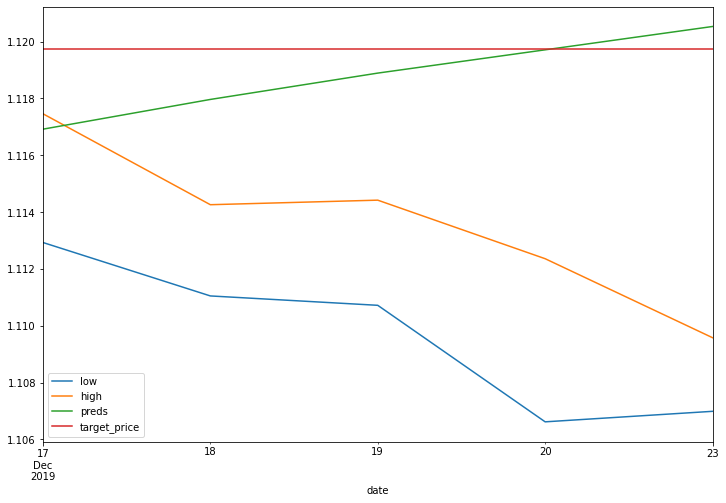

In [72]:
outcomes['low'].plot(legend=True, figsize=(12,8))
outcomes['high'].plot(legend=True)
outcomes['preds'].plot(legend=True);
outcomes['target_price'].plot(legend=True);


In [73]:
arima_results_df = pd.DataFrame(arima_results)
arima_results_df

,name,strategy,date,time_frame,RMSE,MSE,classification
0,arima-0-1-0,fractals,2000-07-28,daily,0.006366,0.000041,tn
1,arima-0-1-0,fractals,2000-08-07,daily,0.014373,0.000207,tp
2,arima-0-1-0,fractals,2000-08-22,daily,0.014946,0.000223,fn
3,arima-0-1-0,fractals,2000-08-29,daily,0.012192,0.000149,fn
4,arima-0-1-0,fractals,2000-09-04,daily,0.017059,0.000291,tp
...,...,...,...,...,...,...,...
607,arima-0-1-0,fractals,2019-10-03,daily,0.001674,0.000003,tn
608,arima-0-1-0,fractals,2019-10-23,daily,0.004562,0.000021,fp
609,arima-0-1-0,fractals,2019-11-18,daily,0.005665,0.000032,fn
610,arima-0-1-0,fractals,2019-11-20,daily,0.007602,0.000058,fp


In [74]:
# Save resutls
arima_results_df.to_csv('/Users/stuartdaw/Documents/Capstone_data/model_results/arima_results_fr.csv', index=False)

# 5.0 Observations